# Jupyter Periscope

Odoo label printing on simple home use label printer.
1. Copy one or more lines from stock adjustment to input box
1. Save the job into printer shared input folder
1. Go pick up the labels

The Printing tool is used when Inventory Adjustments, Stock Moves, Stock Input, Missing box/item label
1st sample case is for stock adjustment. In this case the user will read the lines in Odoo Stock Adjustm line and fills them in.
Onced filled in (if not all the lines) copy the lines to new workbook and sove it print shared folder

Extra to automation tools we would need:
 - [ ] [1h] GoTo Odoo Lot page to get the direct web link
 - [ ] [2h] Generate the ncessaary QR codes as base64 strings
 - [ ] [1h] Opend Draw.io template
 - [ ] [2h] Update Data
 - [ ] [2h] Print
 
 
 Videos To Explain the problem/solution
  - [ ] Automation Step
  - [ ] Automation Workflow
  - [ ] Variables
  - [ ] Web Scrape
  - [ ] Python (Lib QR Code)

## 1. Setup
Load the base code

In [44]:
import time
import pyautogui as gui
import io
import cv2
import numpy as np
import codecs
import dill
from ipywidgets import widgets, Image, Output

class scope():
    """
    scope is an object to create the workflow step remotley using Jupyter-Lab editor remotly using VPN
    """
    @property
    def window(self):
        return self._window
    
    @window.setter
    def window(self, val_in):
        self._window = (val_in[0],val_in[1])
        # set width and height
        self.width = self._window[0][1]-self._window[0][0]
        self.height = self._window[1][1]-self._window[1][0]
    
    def __init__(self, img=None, window=None, area=None, location=None):
        # set the full size image for the step, if no image is provided screenshot is taken automatically
        if img==None:
            self.screenshot = gui.screenshot()
            self.size = self.screenshot.size
        else:
            # ToDo
            print("!!!! ACHTUNG TOfDO !!!!")
            print("it all mnight be bit wier from here on out, You are on YOUR own")
            self.screenshot = img
        
        # area of interest, smallest possible area of the sceren to understand what the step tries to accomplish and if some UI elements change it would be asy to identify the issue and solev it
        if not(window==None):
            self.window = window
        else:
            # make the windiw by default 320x320 top, left corner
            self.window = ((0,0),(320,320))
        
        # area is the subset of window that is uesed as key (looked in end-user computer screen) during step execution.
        if not(area == None):
            self.area = area 
        else:
            self.area = ((self.height/2-30,self.width/2-30),(self.height/2+30,self.width/2+30))
            
        self.area_color = (0,255,255)
        self.area_outline_color = (0,0,255)
            
        if not(location == None):
            self.location = location
        else:
            self.location = (0,0)
            
        self.location_size = 10
        self.location_color = (255,255,0)
        
        # Generate GUI
        self.output = Output()
        self.slider_h = widgets.IntRangeSlider(max=self.size[0], value=(0,320),layout=widgets.Layout(width='90%'),observe=self._update_preview)
        self.slider_v = widgets.IntRangeSlider(max=self.size[1], value=(0,320),layout=widgets.Layout(width='90%'),observe=self._update_preview)
        
        self.offset_x = widgets.IntSlider(max=320//2, min=320//-2, value=0, layout=widgets.Layout(width='90%'),observe=self._update_preview)
        self.offset_y = widgets.IntSlider(max=320//2, min=320//-2, value=0, layout=widgets.Layout(width='90%'),observe=self._update_preview)
        
        self.slider_area_h = widgets.IntRangeSlider(max=320//2, min=320//-2, value=(-32,32), layout=widgets.Layout(width='90%'),observe=self._update_preview)
        self.slider_area_v = widgets.IntRangeSlider(max=320//2, min=320//-2, value=(-32,32), layout=widgets.Layout(width='90%'),observe=self._update_preview)
        
        self.image = widgets.Image()
        self._update_preview(None)
        
        # Add callback functionality
        self.slider_h.observe(self._update_preview)
        self.slider_v.observe(self._update_preview)
        self.offset_x.observe(self._update_preview)
        self.offset_y.observe(self._update_preview)
        self.slider_area_h.observe(self._update_preview)
        self.slider_area_v.observe(self._update_preview)
        
        display(
            widgets.Label(value="Width:"),
            self.slider_h,
            widgets.Label(value="Height:"),
            self.slider_v,
            widgets.Label(value="Out:"),
            self.image, 
            self.output
        )
        
    def _update_preview(self, event):
        # return image with crop, mouse location and unique area
        
        # make sure width and height are at minimu 128px
        self.width = self.slider_h.value[1]-self.slider_h.value[0]
        self.height = self.slider_v.value[1]-self.slider_v.value[0]
        
        if self.width < 128:
            self.slider_h.value = (self.slider_h.value[0], self.slider_h.value[0] + 128)
            
        if self.height < 128:
            self.slider_v.value = (self.slider_v.value[0], self.slider_v.value[0] + 128)
        
        
        # update variables
        self.window = ((self.slider_h.value[0],self.slider_v.value[0]),(self.slider_h.value[1],self.slider_v.value[1]))
        
        
        # TODO make stter for self.window to updtae the width and height
        self.width = self.slider_h.value[1] - self.slider_h.value[0]
        self.height = self.slider_v.value[1] - self.slider_v.value[0]
        # update sliders as well
        self.offset_x.min = self.width//-2
        self.offset_x.max = self.width//2
        self.offset_y.min = self.height//-2
        self.offset_y.max = self.height//2
        self.slider_area_h.min = self.width//-2
        self.slider_area_h.max = self.width//2
        self.slider_area_v.min = self.height//-2
        self.slider_area_v.max = self.height//2
        
        self.location = (self.offset_x.value, self.offset_y.value)
        self.area = ((self.slider_area_h.value[0],self.slider_area_v.value[0]),(self.slider_area_h.value[1],self.slider_area_v.value[1]))
        
        # update image based on new variables
        self.cropped = self.screenshot.crop((self.window[0][0],self.window[0][1],self.window[1][0],self.window[1][1]))
        
        # draw cross
        x_pos = (self.cropped.size[0]//2-1)+self.location[0]
        y_pos = (self.cropped.size[1]//2-1)+self.location[1]
        cropped_cv2 = cv2.cvtColor(np.asarray(self.cropped), cv2.COLOR_BGR2RGB)
        
        self.edited = cv2.line(cropped_cv2,(x_pos,y_pos-self.location_size),(x_pos,y_pos+self.location_size),self.location_color,2)
        self.edited = cv2.line(self.edited,(x_pos-self.location_size,y_pos),(x_pos+self.location_size,y_pos),self.location_color,2)
               
        # Draw Area Marker
        self.transparent = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        cv2.rectangle(self.transparent, (int(self.width//2+self.area[0][0]),int(self.height//2+self.area[0][1])), (int(self.width//2+self.area[1][0]),int(self.height//2+self.area[1][1])), self.area_color, -1)
        self.edited = cv2.addWeighted(self.edited, 1, self.transparent, 0.1, 2.2)
        cv2.rectangle(self.edited, (int(self.width//2+self.area[0][0]),int(self.height//2+self.area[0][1])), (int(self.width//2+self.area[1][0]),int(self.height//2+self.area[1][1])), self.area_outline_color, 1)
        
        # Convert buffer to PNG bytearray
        self.buf = io.BytesIO(cv2.imencode('.png', self.edited)[1].tobytes())

        self.image.format = 'PNG'
        self.image.value = self.buf.getvalue()
    
    def adjust(self):
        display(
            widgets.Label(value="Adsjustments:"),
            widgets.Label(value="X pos:"),
            self.offset_x,
            widgets.Label(value="Y pos:"),
            self.offset_y,
            widgets.Label(value="Area Width:"),
            self.slider_area_h,
            widgets.Label(value="Area Height:"),
            self.slider_area_v
        )
    
    def get_pattern(self):
        crop_x = self.width//2+self.area[0][0]+self.window[0][0]
        crop_y = self.height//2+self.area[0][1]+self.window[0][1]
        crop_w = self.area[1][0]-self.area[0][0]
        crop_h = self.area[1][1]-self.area[0][1]
        
        crp = self.screenshot.crop((
            crop_x,
            crop_y,
            crop_x+crop_w,
            crop_y+crop_h
        ))
        
        return crp
    
    def get_pattern_base64(self):
        return codecs.encode(dill.dumps(self.get_pattern()),"base64").decode()
    
    def get_metadata(self):
        crop_x = self.width//2+self.area[0][0]+self.window[0][0]
        crop_y = self.height//2+self.area[0][1]+self.window[0][1]
        crop_w = self.area[1][0]-self.area[0][0]
        crop_h = self.area[1][1]-self.area[0][1]
        
        
        print("full image size: "+str(self.screenshot.size))
        print("pattern crop window: "+str((
            crop_x,
            crop_y,
            crop_w,
            crop_h
        )))
        crp = self.get_pattern()
        display(crp)
        
        all_found = gui.locateAllOnScreen(test.get_pattern())
        for item in all_found:
            print("    "+str(item))
        
        
        print("mouse location compared to center point of the found pattern: "+str((
            (crop_w//2+crop_x)-(self.window[1][0]//2)-(self.window[0][0]//2)+self.location[0],
            (crop_h//2+crop_y)-(self.window[1][1]//2)-(self.window[0][1]//2)+self.location[1]
        )))
 

## 2. Capture Desktop
Run the cell below, use the widget controls to adjust the parameters unique pattern and mouse location

In [45]:
# TODO Clenaup the GUI
test = scope()

Label(value='Width:')

IntRangeSlider(value=(0, 320), layout=Layout(width='90%'), max=4096)

Label(value='Height:')

IntRangeSlider(value=(0, 320), layout=Layout(width='90%'), max=2160)

Label(value='Out:')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01@\x00\x00\x01@\x08\x02\x00\x00\x00B\xf22\xfd\x00\…

Output()

In [ ]:
test.get_metadata()

In [ ]:
test.adjust()

## 1. Create Workflow Step
Paste the payload block in font of the logic block<br>
Customize the logic block as necessary

In [39]:
import pyperclip
pyperclip.copy("payload = \'\'\'"+test.get_pattern_base64()+"""\'\'\'
pattern_img = dill.loads(codecs.decode(payload.encode(), "base64"))
print("Findig pattern...")
locations = []
locations_found = gui.locateAllOnScreen(pattern_img)
for i in locations_found:
    print(i)
    locations.append(i)
# TODO Create display to show all found areas with outlines
""")

### Step
This step will find XXX and click on XXX

Findig pattern:


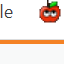

Box(left=128, top=128, width=64, height=64)


In [42]:
payload = '''gASVNDAAAAAAAACMCVBJTC5JbWFnZZSMBUltYWdllJOUKYGUXZQofZSMA1JHQpRLQEtAhpROQgAw
AAD/////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////9/f0iHBqMion////6+vr/////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////+/v4yIhiWj4r/
///////O3M6cv5yh06GY15iT2pOJvYnE28T////9/f3/////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////9/f1CKReZjIT4+Pf4/PiLs4s8jzw+sz4yvzIhviAUhBR8rnz////6/Pr/////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////4+Pc8JxgyIRovKiQ9djxBsEFA5UAg5R8Q
4hEM2gwcgB2NuI3////7/fv/////////////////57JyQEORz///////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////6+voy
IRkmHRMiKhYtnC0lwicb3h0K0gsFuwUKowgkWyOSqJL////7/Pv/////////////////57JyQEOR
z///////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///9+/v9+vr++vn++vn++vn28vArGxkiHhEhMxIlwCQUzRICzQAFtwELjAAaZgo8Oi6alJH7+Pf7
+vr/////////////////57JyQEORz///////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////9+/v////EqqaPTEKmXFGUUkiASkE6ISMdJBMILwYAkgQaeQI9
VwJzPASLMAWeKQedJQp6IxFbKh/6+Pf/////////////////57JyQEORz///////////////////
////////////////////////////////////////////////////////////////////////////
/////////////////////////////////////////////////////////f3MqaPGgXbJYlLRY1LK
Wka8TTmOMCFkJxJBIgNVVgR3SwSdPAa6MQfFLAjMKQjPLAqrJQqGJhL++vr/////////////////
57JyQEORz///////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///9/Pv79PShUEPYaVf/e2T7b1n6Y0jyUzTcPyCqKhGCGQSwHQfSIgnzKAvxLQnwLwruMgv3Mwrc
Lgq+LxL68e/9+/v/////////////57JyQEORz///////////////57JyQEM8QEM8QEM8abLs////
////////////////////////////////////////////////////////////////////////////
//////////////////////////////+ynptzQjredmXta1T2X0TYNRW7KQyiIAauIgbKJwXlKwTv
MQfYKwXAJQSyJAbEJgXZKAXsMArkLgjZMg98Kxu3lY7/////////////57JyQEORz///////////
z488QEORz////////+e1aUM8abLs////////////////////////////////////////////////
//////////////////////////////////////////////////////////+7n5uLRz3tcFvkWD/S
QSSZOCVuIhNKDwNaGg2IJhG3Mhe/LRCYKRJvJBRQEAJtHAyTKxfNLQ3eLgrmMg2JJhK7kYj/////
////////57JyQEORz////////+e1aUM8jdD/////////////57JyQEORz///////////////////
////////////////////////////////////////////////////////////////////////////
///////////Lp6GpVEf8a1PYRiurJgphR0IqJyYACAoMGRtHKyaBPTCFLx1XLiUlLS0AAQQdGRlR
NjGtLxfTLw7wMw2ZKRPElIr/////////////57JyQEORz///////57JyQGy15///////////////
/9CRQENysef/////////////////////////////////////////////////////////////////
///////////////////////////////////////UqqO8XEv3UDG8Pid9NSe0sK9qaWokIR88Ojls
aGeblZR3b214cnF1dHMAAAA/P0CIhYSPV0rBPyTrLAabKhTFk4n/////////////57JyQEORz///
////z488QEM8QEM8QEM8QEM8QEM8QEM8QENysef/////////////////////////////////////
///////////////////////////////////////////////////////////////////XqqPBW0n3
RSS6OiJ+Oy7Ly8urr7CMjIuanJyen5+goqJ8fH2fn5/AwsJra2uSlZa7vLyRYle+QSjoKgaTLRjB
lYv/////////////57JyQEORz///////57JyQGy15///////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////XqKHBV0X1PBm8NxyHQTLd19Xp6unz8O/39fTPy8qoo6CHgYDGwsH////Z
19fk5OPq5eSbaF2+QSnkKgeMNSO+mJH/////////////57JyQEORz////////9CRQENysef/////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////Ro5y0Szn1QBrTMQ+yMBWSeHO0s7LX
4+fG0tWni4aHRDd+NCWjhX7L2Nzj7/LGysynmpmnOCHDLA7fLwpzNimmjYn/////////////57Jy
QEORz//////////ssWw8QEORz////////////+e1jbLs////////////////////////////////
///////////////////////////////////////////////////////////////////////////A
mpOUOirmORbdMAzRLg2wSja2aVq/hHm6emy5V0O3NRq0LhG1VUG2fXPCj4a6eWuyW0rRMxPDKwu1
LhKzlY/Vy8n/////////////57JyQEORz///////////////z488QEM8QEM8QEM8QEORz///////
////////////////////////////////////////////////////////////////////////////
//////////////////////////+0mJJ3MiTWNxnkMQ3uLgjTIwG7IQKoIgavHwHMJQLoKwPqKwPI
JwamIwifKRGuJQjCIQH0MAjALQ+MMR//////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////9+/v68vCWIQrLKgn1Mgnq
MQzqMgzpMg3nMw7oMAvpLgjnMAroMAvpMQvpMw3sMw3sNA3LJgWQMBxSODL59PL+/f3/////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
/////////////PzHk4nCW0bKKgnjMAvpLwjtLwjsMAnrLwjpLgflLgjoLwjrLgjuLgfgLQjOLg2U
LBeXYVannpv8+vn/////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////9+/v////LnpWfKxPXNhTiMw7tNhDsNQ/pNA7l
Mg7dMQ3jMw7oMxDuMw7OLw+sMRhjOzOypaL////8+/v/////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////9+vr9
+fj58O5tJhiLKRahKhKrKxGbLRaKLxt2Lh+QKhWrJw6fKRJ/NCVaOzb38O/7+fj7+/v/////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////+/v60l5G9k4vIlYrMlIjElYu8lo6zlY+/lIvMkofHlIq3
mJKroZ/+/v7/////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
////////////////////////////////////////////////////////////////////////////
///////////////////////////////b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b
3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b
3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b
3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N3b3N30giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0giX0
giX0giX0giX0giX0giX4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4
+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fn4+fmUZWIu
'''
pattern_img = dill.loads(codecs.decode(payload.encode(), "base64"))
print("Findig pattern:")
display(pattern_img)
locations = []
locations_found = gui.locateAllOnScreen(pattern_img)
for i in locations_found:
    print(i)
    locations.append(i)


In [36]:
# Pre-Script
print("Starting step...")
# Post-Script
if len(locations)>0:
    print("found "+str(len(locations))+" locations")
    # UI debounce (opening window time not to click too quick, make it longer if ncessary)
    # Use next step as timeout waiting for progress
    time.sleep(0.01)
    
    # MOUSE
    gui.moveTo(locations[0][0], locations[0][1])
    #gui.click(abs_location[0], abs_location[1])
    #gui.click(abs_location[0], abs_location[1], button='right')
    #gui.click(abs_location[0], abs_location[1], clicks=2)
    
    #exec("out1="+text.value,globals())
    #current_txt = out1       
    #pyperclip.copy(out1)
    #gui.hotkey(os_ctrl(),'v')
    
    #gui.hotkey(os_ctrl(),'a')
    #gui.press('enter')
    
else:
    print("no locations found")


Starting step...
found 1 locations
